Para el segundo nadador que utilizamos cambiamos el criterio que usábamos para elegir el punto de referencia de la posición de la cabeza. Para conservar información sobre la amplitud de la oscilación en la cabeza tomamos como posición de la cabeza el extremo del _blob_ que identificamos como la cabeza que está alineado con el cuello del nadador (se ve más claramente en los ejemplos de procesamiento de un frame). 

Para esto necesitamos recuperar algunos datos intermedios (los frames de interés, el blob completo de la cabeza y la posición de su centro), que, aunque por sí mismos no aportan información nueva sobre el nado, conviene guardar oara acelerar el proceso de análisis de los videos.

Al cambiar el filamento también cambia el código para recuperar la cola.

IMPORTANTE: los videos tienen más particularidades que los que no llevan _checkerboard_, así que en muchos casos hay que elegir manualmente los parámetros adecuados para el análisis de cada uno. Registramos algunos que funcionaban para cada video y los dejamos comentados dentro de las funciones en _utilities.py_. Acá se ejemplifica para el caso de 4Vpp - 5Hz pero si buscamos ver otro video hay que cambiar los parámetros por los correctos comentando y descomentando las líneas correspondientes en cada función.

## Imports y rcParams

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import rcParams
from natsort import natsorted
import os
import pandas as pd
import DSE_prune
import utilities as ut

from skimage.morphology import binary_dilation, remove_small_holes, medial_axis
from skimage.filters import gaussian
from skimage.measure import label, regionprops, regionprops_table
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity 
from skimage.draw import line

from scipy.optimize import curve_fit
f_lineal = lambda x,a,b: a*x + b



THRESHOLD = 100
MAX_PIXEL_VALUE = 255

plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (20, 15)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

## Funciones

In [8]:
def BlobTracker(vs, limites, SHOW=False):
        # obtiene el blob (array) de la cabeza y su centro en cada frame

        pos_x_centroid = []
        pos_y_centroid = []
        blobs = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=-1
        frames = []
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                i+=1
                # procesado previo con el objetivo de filtrar la cola y la mayor cantidad de cuadrados posibles del fondo 
                frame = ut.cortar(frame, limites)
                frame_gray = ut.gris(frame)
                frame_gaussian = gaussian(frame_gray, 4)
                
                # threshold para 4V-5Hz
                frame_binary = 255 - ut.binarize_gray(frame_gaussian, threshold=0.47)

                # threshold para todos los videos con nadador DSK-60 menos 4V-5Hz:
                # frame_binary = 255 - ut.binarize_gray(frame_gaussian, threshold=0.45)

                # identificamos todos los objetos en la imagen binarizada
                labeled_image, _ = label(1-frame_binary, connectivity=1, return_num=True)
                
                # elegimos el de mayor área en píxeles
                object_features = regionprops(labeled_image)
                object_areas = [objf["area"] for objf in object_features]
                object_centroid = [objf["centroid"] for objf in object_features]
                n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
                
                # creamos una máscara para conservar sólo el objeto de mayor área
                mask = np.zeros_like(labeled_image)
                mask += (labeled_image==n+1).astype(int)
                area  =  255 * mask
                
                # obtenemos el centro de ese objeto
                y_centroid, x_centroid = object_centroid[n]

                # analizamos sólo los frames donde 
                # 1) el objeto de mayor área supera un mínimo de área que nos asegure que 
                # estamos detectando la cabeza y no un cuadrado del fondo o la cola. Esto descarta 
                # los frames cuando el nadador todavía está fuera del encuadre.   
                # 2) no se detecte ningún objeto en el extremo izq. Esto descarta los frames cuando 
                # el nadador sale de  encuadre.
                im_izq = area[:, 0:1]
                sum_izq = np.sum(im_izq)

                if object_areas[n] > 200 and sum_izq == 0:
                    frames.append(i)
                    y, x = np.where(area!=0)
                    pos_x_centroid.append(x_centroid)
                    pos_y_centroid.append(y_centroid)

                    blob_mask = np.zeros_like(frame_gray)
                    blob_mask[y, x] = 1
                    blobs.append(blob_mask)

                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (int(x_centroid), int(y_centroid)), radius=1, color=(0, 0, 0), thickness=-1)
                        cv.imshow('frame', frame)
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                else:
                    continue

                if cv.waitKey(1) & 0xFF == ord('q'):
                        break
            else:
                break
        cv.destroyAllWindows()
        vs.release()
        # es importante conservar los frames para poder relacionar trayectoria con deformación superficial
        return np.array(tiempo), np.array(pos_x_centroid), np.array(pos_y_centroid), frames, np.array(blobs)  

def Tracker(vs, limites, blob, x_centroid, y_centroid, frames, SHOW=True):
    # devuelve la posición de la cabeza y la forma de la cola
    start, end = frames[0], frames[-1]   
    pos_x = []
    pos_y = []
    frames = []
    pos_sk = []
    pos_dist = []

    i = -1
    while(vs.isOpened()):
        # print('f')
        ret, frame = vs.read()
        if ret:
            i+=1

            # analizamos sólo los frames donde el nadador está en la región de observación
            # guardar este dato antes acelera mucho el análisis. 
            if i >= start and i <= end:
                frame = ut.cortar(frame, limites)
                frame_gray = ut.gris(frame)

                # enmascaramos la cabeza
                head = np.where(binary_dilation(binary_dilation(blob[i-start]))!=0)
                frame_gray[head] = np.mean(frame_gray)

                # parámetros de binarización para 4V-5Hz:
                if i < start + (end-start)*3//4:
                    _, frame_binary = cv.threshold(frame_gray, 120, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                else:
                    _, frame_binary = cv.threshold(frame_gray, 125, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                
                '''
                # otros parámetros de binarización:
                
                # para todos menos 1V-10Hz, 1V-15Hz, 2V15Hz funca:
                _, frame_binary = cv.threshold(frame_gray, 120, MAX_PIXEL_VALUE, cv.THRESH_BINARY)

                # para todos menos 1V-10Hz, 1V-15Hz, 2V15Hz funca:
                _, frame_binary = cv.threshold(frame_gray, 120, MAX_PIXEL_VALUE, cv.THRESH_BINARY)


                # para 1V-10Hz:
                if i < start + (end-start)*3//5:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 120, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                elif i >= start + (end-start)*4//5:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 140, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                else:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 130, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
 
                # para 1V-15Hz:
                if i < start + (end-start)*3//5:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 122, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                elif i >= start + (end-start)*4//5:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 140, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                else:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 125, MAX_PIXEL_VALUE, cv.THRESH_BINARY)

                # para 2V-10Hz:
                if i < start + (end-start)*2//4:
                    frame_gaussian = gaussian(frame_gray, 1)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 125, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                elif i >= start + (end-start)*3//4:
                    frame_gaussian = gaussian(frame_gray, 2)*255
                    _, frame_binary = cv.threshold(frame_gaussian, 140, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
                else:
                    frame_gaussian = gaussian(frame_gray, 3)*255
                    _, frame_binary = cv.threshold(frame_gray, 120, MAX_PIXEL_VALUE, cv.THRESH_BINARY)     
                '''
                # separamos el objeto de mayor área (habiendo descartado la cabeza, si 
                # preprocesamos bien el frame debería ser la cola)
                
                labeled_image = label(1-frame_binary, connectivity=1)
                object_features = regionprops(labeled_image)
                object_areas = [objf["area"] for objf in object_features]
                n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
                mask = np.zeros_like(labeled_image)
                mask += (labeled_image==n+1).astype(int)
                area  =  mask

                im_der = area[:, -2:-1]
                sum_der = np.sum(im_der)

                # miramos frames donde la porción de cola detectada (el cuello del nadador) tiene
                # más de un área mínima.
                if object_areas[n]>400:
                    frames.append(i)
                    i_c = i - start

                    # sacamos el esqueleto del cuerpo
                    ref_sk, dist = medial_axis(mask, return_distance=True)
                    tail = np.where(area!=0)                
                    
                    y_sk, x_sk = np.where(ref_sk!=0)

                    if sum_der == 0:
                        start_sk = i
                        pos_sk.append(ref_sk)
                        pos_dist.append(dist)
                    
                    # coordenadas del centro de la cabeza en la imagen
                    x_c, y_c = int(x_centroid[i_c]), int(y_centroid[i_c])

                    # coordenadas de la unión del filamento con la cabeza 
                    x_neck, y_neck = np.min(x_sk), y_sk[np.where(x_sk == np.min(x_sk))[0][0]]

                    x_line = x_c + 2*(x_c-x_neck)
                    y_line = y_c + 2*(y_c-y_neck)
                    rr, cc = line(x_c, y_c, x_line, y_line)

                    # posición de la cabeza 
                    y_head, x_head = cc[np.where(blob[i-start][cc, rr]==0)[0][0]], rr[np.where(blob[i-start][cc, rr]==0)[0][0]]

                    pos_x.append(x_head)
                    pos_y.append(y_head)

                    if SHOW:
                        # cabeza
                        frame[np.where(blob[i-start]!=0)] = [0, 255, 0]
                        # cola
                        frame[tail] = [0, 255, 255]
                        # esqueleto
                        frame[y_sk, x_sk] = [0,0,0]
                        # eje
                        frame[cc, rr] = [255, 0, 0]
                        # centro
                        frame = cv.circle(frame, (x_c, y_c), radius=1, color=(0, 0, 0), thickness=5)
                        # cuello
                        frame = cv.circle(frame, (x_neck, y_neck), radius=1, color=(255, 0, 255), thickness=5)
                        # fin del eje
                        frame = cv.circle(frame, (x_line, y_line), radius=1, color=(255, 0, 0), thickness=5)
                        # pos de la cabeza
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=5)
                        cv.imshow('frame', frame)

                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
                
        else:
            break
    cv.destroyAllWindows()
    vs.release()
    return pos_x, pos_y, frames, np.array(pos_sk), np.array(pos_dist), start_sk



## Aplicación: 

Usamos de ejemplo el video para 4 Vpp y 5 Hz.

In [3]:
FILENAME='4V-5Hz'
vs = cv.VideoCapture(f'examples\\example_media\\P1-{FILENAME}-60mm.mp4')
lim = [0, 1280, 110, 600]
t, x_centroid, y_centroid, f, blobs = BlobTracker(vs, lim, SHOW=True)

# guardamos los datos:

pd.DataFrame().assign(t=t[:len(x_centroid)]).assign(x_centroid=x_centroid).assign(y_centroid=y_centroid).assign(frame=f).to_csv(f'examples\\example_media\\{FILENAME}-centroid.csv')
np.savez(f'examples\\example_media\\{FILENAME}-blob', arr = blobs)

pd.DataFrame().assign(t=t[:len(x_centroid)]).assign(x_centroid=x_centroid).assign(y_centroid=y_centroid).assign(frame=f).to_csv(f'datos\\60mm\\centroid\\{FILENAME}-c.csv')
np.savez(f'datos\\60mm\\blobs\\{FILENAME}-b', arr = blobs)

Para agilizar el análisis conviene guardar los datos de la cabeza y la posición del centro de la misma en CSV cuando se los detecta adecuadamente, de modo que si se modifica la función _trayectoria()_, que da la posición definitiva de la cabeza, no sea necesario volver a generar los datos intermedios de _blobs_ y _centroid_. Esta función requiere sí o sí que se le ajusten los parámetros manualmente para poder aplicarla en cada video. 

Conviene generar estos archivos para todos los videos como primera instancia y después leer esos datos para meterlos en _trayectoria()_. En el Drive están los archivos de _blob_ y _centroid_ que guardamos para cada video estudiado. Usamos acá los de 4 Vpp 5 Hz.

In [4]:
# cargamos los datos de la cabeza y el centroid
df = pd.read_csv(f'examples\\example_media\\{FILENAME}-centroid.csv')
t, x_centroid, y_centroid, f = df['t'], np.array(df['x_centroid']), np.array(df['y_centroid']), np.array(df['frame'])
blobs = np.array(np.load(f'examples\\example_media\\{FILENAME}-blob.npz', allow_pickle=True)['arr'])

Por irregularidades en la iluminación del fondo en la mayoría de los casos hay que elegir thresholds distintos en diferentes regiones de la imagen por la diferencia en las ondas que generan con distinta activación (y por lo tanto en la deformación del patrón del fondo) hay que variar los thresholds (y hasta método de binarización) para eliminar la mayor cantidad de cuadrados del fondo posibles manteniendo una buena detección (una buena deteccción consiste en recuperar el esqueleto sin demasiadas ramas y con su extremo fijo a la cabeza) del filamento en la zona del cuello del nadador. 


In [ ]:
vs = cv.VideoCapture(f'examples\\example_media\\P1-{FILENAME}-60mm.mp4')
x_head, y_head, frames, pos_sk, pos_dist, start_sk= Tracker(vs, lim, blobs, x_centroid, y_centroid, f, SHOW=True)

# guardamos los datos:
# pd.DataFrame().assign(t=t[:len(x_head)]).assign(x=x_head).assign(y=y_head).assign(frame=frames).to_csv(f'datos\\60mm\\new\\{FILENAME}-new.csv')
# np.savez(f'examples\\example_media\\{FILENAME}-sk', arr = pos_sk)
# np.savez(f'examples\\example_media\\{FILENAME}-dist', arr = pos_dist)

In [7]:
skel = np.array(np.load(f'examples\\example_media\\{FILENAME}-sk.npz', allow_pickle=True)['arr'])
dist = np.array(np.load(f'examples\\example_media\\{FILENAME}-dist.npz', allow_pickle=True)['arr'])
print(f'frame a partir del cual empiezo a guardar la forma de la cola: {start_sk}')

frame a partir del cual empiezo a guardar la forma de la cola: 261


Sólo tenemos analizado el caso 4V - 5Hz mirando la forma de la cola. Se pueden eliminar las ramas posteriormente con el algoritmo de _pruning_, para tener datos más suaves y hacer análisis similares a los que obtuvimos para el primer nadador. Es preciso pero muy lento, por eso se guardó sin procesar. 

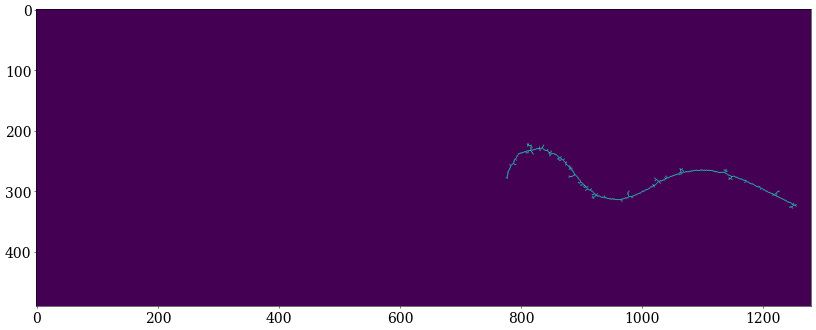

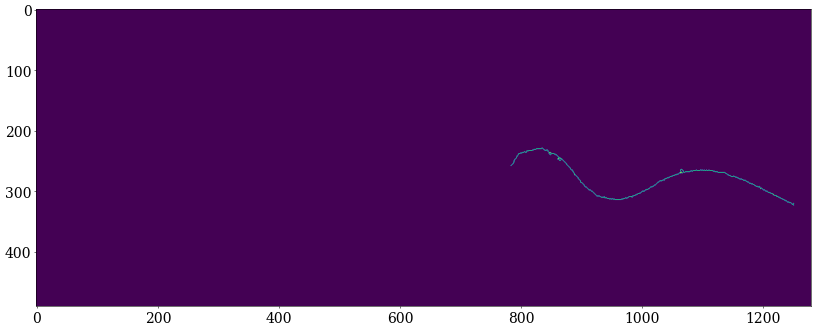

In [18]:
plt.figure()
plt.imshow(skel[2])
dse = DSE_prune.skel_pruning_DSE(skel[2], dist[2], 100)
plt.figure()
plt.imshow(dse)

In [ ]:
# código para guardar blob y centroid de forma automática en casos que no son 4V-5Hz. 
# hay que cambiar el threshold en la función BlobTracker.


already_processed = [data.replace('.csv','') for data in os.listdir('datos\\60mm\\centroid\\')]
# print(already_processed)

for filename in os.listdir('videos\\FCD\\P1\\telgopor\\'):
    video = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    spl = filename[:-4].split('-')
    v,f = spl[1],spl[2]
    if f'{v}-{f}-c' not in already_processed:
        try:
            t,x_c,y_c,frame,blob = BlobTracker(video, lim, SHOW=False)
            # Guardo los datos
            if x_c.size>0 and y_c.size>0:
                pd.DataFrame().assign(t=t[:len(x_c)]).assign(x_centroid=x_c).assign(y_centroid=y_c).assign(frame=frame).to_csv(f'datos\\60mm\\centroid\\{v}-{f}-c.csv')
                np.savez(f'datos\\60mm\\blobs\\{FILENAME}-b', arr = blobs)
                print(f'guardado: {filename}')
            else:
                print("No data ", filename)
        except:
            print(f'No se pudo, archivo: {filename}')
    print('siguiente')

guardado: P1-1V-10Hz-60mm.mp4
siguiente
No se pudo, archivo: P1-1V-15Hz-60mm.mp4
siguiente
No se pudo, archivo: P1-1V-5Hz-60mm.mp4
siguiente


Una vez que ya tenemos cada CSV de la posición de la cabeza obtenemos y guardamos la velocidad terminal para cada caso 

In [10]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
#sobre la carpeta con todos los csv de pos de cabeza
csv_names = natsorted([filepath for filepath in os.listdir('datos\\60mm\\new') if '.csv' in filepath])
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'datos\\60mm\\new\\{f}') for f in filenamelist['name']]

In [11]:
df_namelist = filenamelist[filenamelist['name'].str.contains('V')] #We get the filenames corresponding to the frequency chosen
filtered_namelist = df_namelist['name'] #We get the names of those files
print(filtered_namelist)

0     1V-5Hz-new.csv
1    1V-10Hz-new.csv
2    1V-15Hz-new.csv
3     2V-5Hz-new.csv
4    2V-10Hz-new.csv
5     3V-5Hz-new.csv
6    3V-10Hz-new.csv
7     4V-5Hz-new.csv
Name: name, dtype: object


In [23]:
volt_list = []
frec_list = []
vel_list = []
vel_err_list = []
start_frame = []
end_frame = []

for i, filename in enumerate(filtered_namelist):
    print(f'leyendo: {filename}')
    
    df_txy = df[i] #We retrieve the dataframe corresponding to our current filename
    #We retrieve the metadata of our measurements from the filename

    s = filename.split('.')[0].split('-')
    v,f = s[0],s[1]
    vval = (float(v.split('V')[0].replace(',','.')))
    fval = float(f.split('Hz')[0].replace(',','.'))
    volt_list.append(vval)
    frec_list.append(fval)

    # #We retrieve the data from our dataframe
    t,x,frame = np.array(df_txy['t']), np.array(df_txy['x']), np.array(df_txy['frame'])#, np.array(df_txy['y_centroid'])
    frame = frame - 1
    start_frame.append(frame[0])
    end_frame.append(frame[-1])

    popt, popv = curve_fit(f_lineal, t, x)
    a, b = popt
    err_popt = np.sqrt(np.diag(popv))
    a_err, b_err = err_popt
    vel_list.append(a)
    vel_err_list.append(a_err)

# guardamos los datos:
# pd.DataFrame().assign(frec=frec_list).assign(volt=volt_list).assign(vel=vel_list).assign(vel_err=vel_err_list).assign(start_frame=start_frame).assign(end_frame=end_frame).to_csv(f'datos\\60mm\\new\\velocidades-new.csv')


leyendo: 1V-5Hz-new.csv
leyendo: 1V-10Hz-new.csv
leyendo: 1V-15Hz-new.csv
leyendo: 2V-5Hz-new.csv
leyendo: 2V-10Hz-new.csv
leyendo: 3V-5Hz-new.csv
leyendo: 3V-10Hz-new.csv
leyendo: 4V-5Hz-new.csv
